In [1]:
import torch
import torchvision
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
#%matplotlib inline
import numpy as np

# Import and split dataset

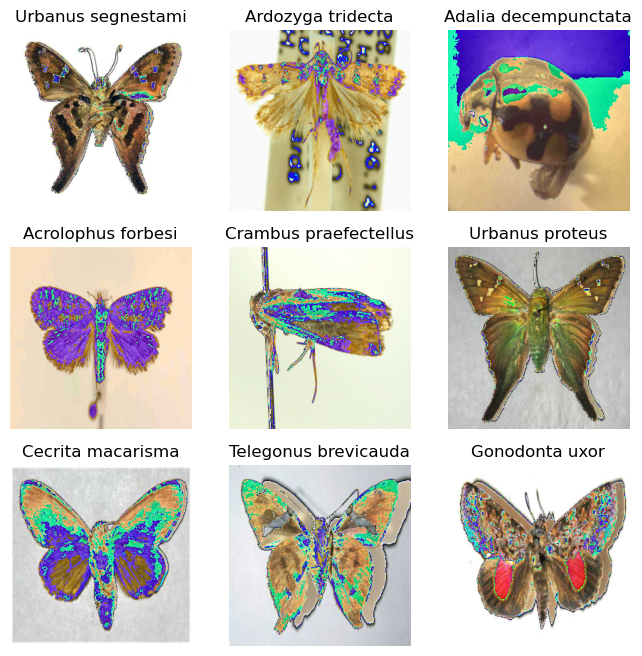

In [2]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((256,256)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_dataset), size=(1,)).item()
    img, label = image_dataset[sample_idx]
    img = transforms.functional.to_pil_image(img)
    figure.add_subplot(rows, cols, i)
    species_name = (list(image_dataset.class_to_idx.keys())[label]).replace('_',' ')
    plt.title(species_name)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [3]:
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_1, X_test, y_train_1, y_test = dataset_utils.data_split(nucleotides,0.3)
print(y_test)
train_data = X_train_1
train_data['species_name'] = y_train_1

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)
from torch.utils.data import Dataset, DataLoader
 
class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
        
whole_dataset = WholeDataset(image_dataset)
n_classes = np.unique(whole_dataset.targets).shape[0]
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)

365    Bembidion normannum
292       Bledius gallicus
321       Praxis edwardsii
352        Andrena pilipes
18     Automeris managuana
              ...         
412         Hemiceras losa
413         Hemiceras losa
417     Hemiceras punctata
418         Hemiceras losa
421     Hemiceras punctata
Name: species_name, Length: 12052, dtype: object
32424


32424

{645: 0,
 643: 1,
 654: 2,
 640: 3,
 641: 3,
 644: 0,
 652: 4,
 658: 5,
 655: 6,
 657: 5,
 642: 3,
 648: 0,
 647: 0,
 661: 7,
 659: 8,
 646: 0,
 650: 9,
 649: 0,
 651: 10,
 660: 11,
 653: 12,
 656: 13,
 465: 14,
 456: 15,
 458: 15,
 461: 15,
 463: 15,
 460: 15,
 464: 15,
 457: 15,
 462: 15,
 459: 15,
 357: 16,
 347: 17,
 353: 18,
 354: 18,
 348: 17,
 351: 17,
 345: 17,
 349: 17,
 350: 17,
 352: 17,
 356: 16,
 355: 18,
 346: 17,
 344: 17,
 916: 19,
 913: 20,
 923: 21,
 912: 22,
 910: 23,
 921: 24,
 914: 20,
 922: 21,
 924: 21,
 925: 21,
 917: 19,
 915: 19,
 919: 25,
 911: 26,
 918: 25,
 909: 27,
 920: 24,
 1037: 28,
 1035: 28,
 1036: 28,
 125: 29,
 116: 30,
 124: 29,
 131: 29,
 119: 31,
 122: 32,
 118: 31,
 111: 33,
 120: 34,
 113: 35,
 123: 36,
 129: 29,
 117: 30,
 110: 33,
 130: 29,
 127: 29,
 126: 29,
 115: 30,
 128: 29,
 121: 34,
 112: 33,
 46: 37,
 51: 38,
 66: 39,
 59: 39,
 68: 39,
 64: 39,
 61: 39,
 67: 39,
 53: 39,
 49: 40,
 55: 39,
 47: 37,
 45: 37,
 48: 37,
 57: 39,
 69: 39,
 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_size = 100 
batch_size =  64

In [ ]:
train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=True, num_workers=2)
del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

print(len(train_imgs.indices))
print(len(val_imgs.indices))
print(len(test_imgs.indices))


# Initialize and train the models

In [ ]:
import os 
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(100, latent_size, 1, 1,device=device)
sample_random_classes = torch.tensor(np.random.randint(0, n_classes, fixed_latent.shape[0]),device=device)

In [26]:
import importlib
import modelA2 as m
importlib.reload(m)

discriminator = m.Discriminator()
discriminator.cuda()
generator = m.Generator(noise_size=100)
generator.cuda()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.5, 0.999))
#discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(),lr=1e-5)
#generator_optimizer = torch.optim.RMSprop(generator.parameters(),lr=1e-5)
generator_optimizer = torch.optim.Adam(generator.parameters(),lr=2e-4,betas=(0.5, 0.999))


n_params = dataset_utils.count_trainable_parameters(discriminator);
print(n_params)
n_params = dataset_utils.count_trainable_parameters(generator);
print(n_params)


writer = SummaryWriter()

32292891
30259312


In [ ]:
from dataset_utils import Fit_params, Save_samples_params
with torch.no_grad():
    pass
fit_p = Fit_params(discriminator_optimizer,generator_optimizer,discriminator,generator,dataloaders,device,writer,batch_size,n_classes,latent_size)
save_p = Save_samples_params(fixed_latent,sample_random_classes,sample_dir)
losses_g, losses_d ,real_scores, fake_scores =m.fit(100,fit_p,save_p,start_idx=1)

  0%|          | 0/169 [00:00<?, ?it/s]

/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/100], loss_g: 0.7552, loss_d: 1.8961, real_score: 0.3956, fake_score: 0.5285
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0001.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 0.3882, loss_d: 1.7782, real_score: 0.5516, fake_score: 0.6658
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0002.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 0.6444, loss_d: 1.3069, real_score: 0.5472, fake_score: 0.5071
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0003.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 0.7103, loss_d: 1.3853, real_score: 0.4897, fake_score: 0.4964
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0004.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 0.7706, loss_d: 1.3115, real_score: 0.5085, fake_score: 0.4809
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0005.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 0.7197, loss_d: 1.3057, real_score: 0.5374, fake_score: 0.5202
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0006.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 0.7091, loss_d: 1.3811, real_score: 0.5113, fake_score: 0.4987
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0007.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 0.7526, loss_d: 1.3834, real_score: 0.5060, fake_score: 0.4935
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0008.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 0.7152, loss_d: 1.3555, real_score: 0.5014, fake_score: 0.5153
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0009.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 0.7034, loss_d: 1.3189, real_score: 0.5573, fake_score: 0.5124
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0010.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 0.7142, loss_d: 1.4931, real_score: 0.4557, fake_score: 0.4968
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0011.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 0.7543, loss_d: 1.3803, real_score: 0.4993, fake_score: 0.5051
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0012.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 0.7358, loss_d: 1.4060, real_score: 0.4968, fake_score: 0.4967
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0013.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 0.7131, loss_d: 1.3656, real_score: 0.4943, fake_score: 0.4925
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0014.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 0.6835, loss_d: 1.4187, real_score: 0.4811, fake_score: 0.5087
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0015.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 0.7335, loss_d: 1.2732, real_score: 0.5219, fake_score: 0.4961
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0016.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 0.6783, loss_d: 1.4196, real_score: 0.5047, fake_score: 0.5138
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0017.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 0.6630, loss_d: 1.3900, real_score: 0.4959, fake_score: 0.5270
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0018.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 0.7035, loss_d: 1.2860, real_score: 0.5525, fake_score: 0.5125
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0019.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 0.6526, loss_d: 1.4333, real_score: 0.4796, fake_score: 0.5313
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0020.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 0.6797, loss_d: 1.4270, real_score: 0.4854, fake_score: 0.5089
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0021.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 0.7196, loss_d: 1.4309, real_score: 0.4856, fake_score: 0.4973
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0022.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 0.7214, loss_d: 1.3458, real_score: 0.4965, fake_score: 0.5090
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0023.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 0.7064, loss_d: 1.3654, real_score: 0.5128, fake_score: 0.4941
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0024.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 0.6662, loss_d: 1.4566, real_score: 0.4881, fake_score: 0.5140
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0025.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 0.6872, loss_d: 1.4231, real_score: 0.5061, fake_score: 0.5121
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0026.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 0.6746, loss_d: 1.3649, real_score: 0.4992, fake_score: 0.5162
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0027.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 0.7193, loss_d: 1.3166, real_score: 0.5273, fake_score: 0.4877
class accuracy real 0.0
class accuracy fake 0.015625
Saving generated-images-0028.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 0.7249, loss_d: 1.4365, real_score: 0.4973, fake_score: 0.5150
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0029.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 0.7207, loss_d: 1.3995, real_score: 0.5090, fake_score: 0.5070
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0030.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 0.7255, loss_d: 1.3799, real_score: 0.4993, fake_score: 0.4880
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0031.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 0.7041, loss_d: 1.3168, real_score: 0.4981, fake_score: 0.5027
class accuracy real 0.03125
class accuracy fake 0.015625
Saving generated-images-0032.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 0.6980, loss_d: 1.3694, real_score: 0.5167, fake_score: 0.5067
class accuracy real 0.0
class accuracy fake 0.015625
Saving generated-images-0033.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 0.6975, loss_d: 1.4173, real_score: 0.4837, fake_score: 0.4976
class accuracy real 0.0
class accuracy fake 0.015625
Saving generated-images-0034.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 0.7043, loss_d: 1.4054, real_score: 0.4891, fake_score: 0.5106
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0035.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 0.7053, loss_d: 1.4252, real_score: 0.4945, fake_score: 0.5073
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0036.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 0.6989, loss_d: 1.3668, real_score: 0.5271, fake_score: 0.5034
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0037.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 0.6772, loss_d: 1.3827, real_score: 0.4988, fake_score: 0.5075
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0038.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 0.6938, loss_d: 1.2915, real_score: 0.4907, fake_score: 0.5008
class accuracy real 0.046875
class accuracy fake 0.015625
Saving generated-images-0039.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 0.7230, loss_d: 1.3735, real_score: 0.5261, fake_score: 0.5109
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0040.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 0.7356, loss_d: 1.3371, real_score: 0.5068, fake_score: 0.4950
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0041.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 0.7164, loss_d: 1.3509, real_score: 0.4955, fake_score: 0.4902
class accuracy real 0.015625
class accuracy fake 0.0
Saving generated-images-0042.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 0.6999, loss_d: 1.2989, real_score: 0.5014, fake_score: 0.5081
class accuracy real 0.046875
class accuracy fake 0.0
Saving generated-images-0043.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 0.7157, loss_d: 1.3880, real_score: 0.5301, fake_score: 0.5194
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0044.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 0.7265, loss_d: 1.3957, real_score: 0.4897, fake_score: 0.4847
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0045.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 0.6598, loss_d: 1.4081, real_score: 0.5017, fake_score: 0.5039
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0046.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 0.7106, loss_d: 1.4354, real_score: 0.4670, fake_score: 0.4822
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0047.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 0.7077, loss_d: 1.4578, real_score: 0.4806, fake_score: 0.5046
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0048.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 0.7588, loss_d: 1.3849, real_score: 0.5191, fake_score: 0.5089
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0049.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 0.6601, loss_d: 1.4503, real_score: 0.5025, fake_score: 0.5213
class accuracy real 0.0
class accuracy fake 0.0
Saving generated-images-0050.png


  0%|          | 0/169 [00:00<?, ?it/s]

In [ ]:

dataset_utils.species_label_to_genus_label()

# Altra roba

In [ ]:
raise Exception
torch.save({
            'epoch':100,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': generator_optimizer.state_dict(),
            }, "checkpoints/_")
torch.save({
            'epoch': 100,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': discriminator_optimizer.state_dict(),
            }, "checkpoints/_")

In [ ]:
image_dataset.class_to_idx['Hemiceras_nigrescens']

In [ ]:
image_dataset.class_to_idx['Abax_parallelepipedus']

In [ ]:
raise Exception
fixed_latent2 = torch.randn(1, latent_size, 1, 1,device=device)

for class_fix in range(len(image_dataset.class_to_idx)):
    random_classes = torch.tensor(np.random.randint(class_fix, class_fix+1, fixed_latent2.shape[0]),device=device)
    print(random_classes)
    specie_name = list(image_dataset.class_to_idx.keys())[class_fix]
    specie_name_no_underscore= specie_name.replace("_"," ")
    if specie_name_no_underscore in list(X_train['species_name']):
        fake_images = generator(fixed_latent2,random_classes)
        fake_fname = f'{specie_name}.png'
        save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
        #writer.add_image('sample image',denorm(fake_images[0]),global_step=index)
        print('Saving', fake_fname)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    

In [ ]:
'Nola cucllatella' in list(X_train['species_name'])

In [ ]:
X_train['species_name']

In [ ]:

ct = nn.ConvTranspose2d( 100+embedding_size, 64 * 8, 4, 1, 0, bias=False)

In [ ]:
i = torch.ones(32,1100,1,1)

In [ ]:
x = ct(i)
print(x.shape)
up = nn.Upsample(scale_factor=2, mode='bilinear')
x = up(x)
print(x.shape)
conv1 = nn.Conv2d(64*8,64*8,1)
x = conv1(x)
print(x.shape)
x = up(x)
print(x.shape)
conv2 = nn.Conv2d(64*8,64*4,1)
x = conv2(x)
print(x.shape)
x = up(x)
print(x.shape)
conv3 = nn.Conv2d(64*4,64*2,1)
x = conv3(x)
print(x.shape)
x = up(x)
print(x.shape)
conv4 = nn.Conv2d(64*2,64*1,1)
x = conv4(x)
print(x.shape)
x = up(x)
print(x.shape)
conv5 = nn.Conv2d(64*1,3,1)
x = conv5(x)
print(x.shape)
x = up(x)
print(x.shape)

In [ ]:
a = torch.eye(2,3)
a[0][0]=2
a[0][1]=3
a

In [ ]:
a.mean(1)

In [ ]:
a.shape